In [1]:
from datasets import load_dataset, load_metric

raw_datasets = load_dataset("wmt17", "zh-en", cache_dir="/data2/hanyings/.cache")
metric = load_metric("sacrebleu")

/data2/hanyings/conda_envs/tnmt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset wmt17 (/data2/hanyings/.cache/wmt17/zh-en/1.0.0/2d49e0ac9500439706ca425bb2059f0db0d024ab28ca19b0b64fc0030a714953)
100%|██████████| 3/3 [00:36<00:00, 12.07s/it]
/tmp/ipykernel_28914/2303173043.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("sacrebleu")


In [2]:
from transformers import AutoModelWithLMHead,AutoTokenizer,pipeline, MarianTokenizer, MarianTokenizer, TFMarianMTModel, AutoModelForSeq2SeqLM
import torch
mode_name = '/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =AutoModelForSeq2SeqLM.from_pretrained(mode_name)
tokenizer = AutoTokenizer.from_pretrained(mode_name, return_tensors="pt")

2023-01-23 15:06:28.926470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 15:06:34.131320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:$LD_LIBRARY_PATH
2023-01-23 15:06:34.132000: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.2/lib64:$LD_LIBRARY_PATH
2023-01-23 15:06:34.132031: W tensorflow/c

In [3]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 25134743
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2002
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2001
    })
})

In [4]:
split = raw_datasets["train"].train_test_split(test_size=1)
raw_datasets["train"] = split["test"]
raw_datasets["validation"] = split["test"]
raw_datasets["test"] = split["test"]
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1
    })
})

In [5]:
# prefix = ""
# max_input_length = 128
# max_target_length = 128
# source_lang = "en"
# target_lang = "zh"
# def preprocess_function(examples):
#     inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
#     targets = [ex[target_lang] for ex in examples["translation"]]
#     model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
#     # Setup the tokenizer for targets
#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(targets, max_length=max_target_length, truncation=True)
#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

In [6]:
preprocess = preprocess_function(raw_datasets['train'][:1])
preprocess

NameError: name 'preprocess_function' is not defined

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)
tokenized_datasets

: 

In [ ]:
tokenized_datasets["train"][0]

: 

In [ ]:
token = tokenized_datasets["train"][0]["input_ids"][1]
token

: 

In [ ]:

old_embed = model.get_encoder().embed_tokens(torch.tensor(tokenized_datasets["train"][0]["input_ids"]))
old_embed

: 

In [ ]:
old_embed.size()

: 

Retrain model

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import os
os.environ["WANDB_DISABLED"] = "true"
args = Seq2SeqTrainingArguments(
    "./tmp_trainer",
    evaluation_strategy = "epoch", # evaluate on valid dataset at emd pf each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=10,
    predict_with_generate=True,
    metric_for_best_model = "bleu",  #Must be the name of a metric returned by the evaluation with or without the prefix "eval_".
    # bleu in the compute metric ?   
    save_strategy="no"
    
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenize="zh",smooth_method="add-k")
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["train"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

: 

In [ ]:
model.to("cpu")
new_embed = model.get_encoder().embed_tokens(torch.tensor([token]))
new_embed

: 

In [ ]:
from scipy.spatial.distance import cosine
1 - cosine(old_embed[0].detach().numpy(), new_embed[0].detach().numpy())

: 

In [ ]:
from datasets.arrow_dataset import Dataset
Dataset.from_dict(preprocess)

: 

Functions wrapup

In [7]:
from transformers import AutoModelWithLMHead,AutoTokenizer,pipeline, MarianTokenizer, MarianTokenizer, TFMarianMTModel, AutoModelForSeq2SeqLM
import torch
mode_name = '/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model =AutoModelForSeq2SeqLM.from_pretrained(mode_name)
tokenizer = AutoTokenizer.from_pretrained(mode_name, return_tensors="pt")
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("wmt17", "zh-en", cache_dir="/data2/hanyings/.cache")
metric = load_metric("sacrebleu")

from datasets.arrow_dataset import Dataset
prefix = ""
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "zh"
def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    model_inputs["translation"] = examples["translation"]
    return model_inputs

Found cached dataset wmt17 (/data2/hanyings/.cache/wmt17/zh-en/1.0.0/2d49e0ac9500439706ca425bb2059f0db0d024ab28ca19b0b64fc0030a714953)
100%|██████████| 3/3 [00:04<00:00,  1.58s/it]


In [8]:
from datasets import load_dataset, load_metric
def preprocess_dataset(num_ex):
    raw_datasets = load_dataset("wmt17", "zh-en", cache_dir="/data2/hanyings/.cache")   
    preprocess = preprocess_function(raw_datasets['test'][num_ex:num_ex+1])
    return Dataset.from_dict(preprocess)
    

In [9]:
dataset = preprocess_dataset(0)
dataset

Found cached dataset wmt17 (/data2/hanyings/.cache/wmt17/zh-en/1.0.0/2d49e0ac9500439706ca425bb2059f0db0d024ab28ca19b0b64fc0030a714953)
100%|██████████| 3/3 [00:00<00:00, 89.88it/s]


Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'translation'],
    num_rows: 1
})

In [10]:
dataset[0]

{'input_ids': [1515,
  16,
  40836,
  16,
  2283,
  14521,
  54145,
  34836,
  35066,
  48,
  6203,
  33288,
  4473,
  294,
  0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [8,
  832,
  2191,
  29232,
  5569,
  30676,
  17648,
  47548,
  6396,
  4054,
  3322,
  0],
 'translation': {'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
  'zh': '28岁厨师被发现死于旧金山一家商场'}}

In [11]:
from transformers import AutoModelWithLMHead,AutoTokenizer,pipeline, MarianTokenizer, MarianTokenizer, TFMarianMTModel, AutoModelForSeq2SeqLM
import torch
def get_old_embed(dataset):
    mode_name = '/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000'
    model =AutoModelForSeq2SeqLM.from_pretrained(mode_name)
    return model.get_encoder().embed_tokens(torch.tensor(dataset[0]["input_ids"]))

In [12]:
old_embed = get_old_embed(dataset)
old_embed.size()

torch.Size([15, 512])

In [13]:
old_embed

tensor([[ 0.0302, -0.0172, -0.0018,  ..., -0.0416, -0.0139, -0.0428],
        [ 0.0156, -0.0056, -0.0127,  ..., -0.0440, -0.0054, -0.0512],
        [-0.0072,  0.0084, -0.0037,  ..., -0.0056, -0.0071, -0.0122],
        ...,
        [ 0.0250,  0.0081,  0.0076,  ..., -0.0586, -0.0069, -0.0583],
        [ 0.0025,  0.0084, -0.0172,  ...,  0.0006, -0.0552, -0.0475],
        [ 0.0114,  0.0351, -0.0119,  ..., -0.0167, -0.0144, -0.0326]],
       grad_fn=<EmbeddingBackward0>)

In [14]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import os
def retrain(dataset):
    mode_name = '/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000'
    model =AutoModelForSeq2SeqLM.from_pretrained(mode_name)
    tokenizer = AutoTokenizer.from_pretrained(mode_name, return_tensors="pt")
    
    os.environ["WANDB_DISABLED"] = "true"
    args = Seq2SeqTrainingArguments(
        "./tmp_trainer",
        evaluation_strategy = "epoch", # evaluate on valid dataset at emd pf each epoch
        learning_rate=2e-5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=1,
        predict_with_generate=True,
        metric_for_best_model = "bleu",  #Must be the name of a metric returned by the evaluation with or without the prefix "eval_".
        # bleu in the compute metric ?   
        save_strategy="no"
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

    import numpy as np
    def postprocess_text(preds, labels):
        preds = [pred.strip() for pred in preds]
        labels = [[label.strip()] for label in labels]
        return preds, labels
    def compute_metrics(eval_preds):
        preds, labels = eval_preds
        if isinstance(preds, tuple):
            preds = preds[0]
        decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
        # Some simple post-processing
        decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
        result = metric.compute(predictions=decoded_preds, references=decoded_labels, tokenize="zh",smooth_method="add-k")
        result = {"bleu": result["score"]}
        prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
        result["gen_len"] = np.mean(prediction_lens)
        result = {k: round(v, 4) for k, v in result.items()}
        return result

    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=dataset,
        eval_dataset=dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    return model, tokenizer

In [15]:
model, tokenizer = retrain(dataset)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set  don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation.
***** Running training *****
  Num examples = 1
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,No log,0.982262,77.979200,11.000000


The following columns in the evaluation set  don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation.
***** Running Evaluation *****
  Num examples = 1
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




In [16]:
def get_new_embed(model, dataset):
    model.to("cpu")
    return model.get_encoder().embed_tokens(torch.tensor(dataset[0]["input_ids"]))


In [17]:
new_embed = get_new_embed(model, dataset)
new_embed

tensor([[ 0.0302, -0.0171, -0.0018,  ..., -0.0416, -0.0140, -0.0428],
        [ 0.0156, -0.0056, -0.0127,  ..., -0.0440, -0.0054, -0.0512],
        [-0.0071,  0.0085, -0.0037,  ..., -0.0056, -0.0071, -0.0123],
        ...,
        [ 0.0251,  0.0081,  0.0075,  ..., -0.0586, -0.0069, -0.0583],
        [ 0.0025,  0.0084, -0.0172,  ...,  0.0006, -0.0552, -0.0476],
        [ 0.0114,  0.0350, -0.0119,  ..., -0.0167, -0.0143, -0.0327]],
       grad_fn=<EmbeddingBackward0>)

In [18]:
from scipy.spatial.distance import cosine

def cosine_sim(dataset, old_embed, new_embed):
    output = dataset[0]
    output["cosine_sim"] = []
    for i in range(len(old_embed)):
        cos = 1 - cosine(old_embed[i].detach().numpy(), new_embed[i].detach().numpy())
        output["cosine_sim"].append(cos)
    return output

In [19]:
cosine_data = cosine_sim(dataset, old_embed, new_embed)
cosine_data

{'input_ids': [1515,
  16,
  40836,
  16,
  2283,
  14521,
  54145,
  34836,
  35066,
  48,
  6203,
  33288,
  4473,
  294,
  0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [8,
  832,
  2191,
  29232,
  5569,
  30676,
  17648,
  47548,
  6396,
  4054,
  3322,
  0],
 'translation': {'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
  'zh': '28岁厨师被发现死于旧金山一家商场'},
 'cosine_sim': [0.9999998807907104,
  0.9999997615814209,
  0.9999998807907104,
  0.9999997615814209,
  0.9999998807907104,
  0.9999999403953552,
  0.9999997615814209,
  0.9999997019767761,
  0.9999998807907104,
  0.9999998807907104,
  0.9999998211860657,
  0.9999998211860657,
  0.9999998807907104,
  0.9999997615814209,
  0.9999998211860657]}

In [20]:
tokenizer.convert_ids_to_tokens(51091)

'▁1929'

In [21]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import string 

def top_k_token(dataset_cos, tokenizer, k=3):
    idx = np.argsort(dataset_cos["cosine_sim"])[:k]
    input_tokens = [dataset_cos['input_ids'][i] for i in idx ]
    return [tokenizer.decode(t) for t in input_tokens if tokenizer.decode(t) not in string.punctuation]

In [22]:
top_k_token(cosine_data, tokenizer)

['Found']

In [23]:
import nltk
from nltk.corpus import stopwords
import string 
nltk.download('stopwords')
sw_nltk = stopwords.words('english')
punc = string.punctuation
print(sw_nltk)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/as/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
tokenizer.convert_tokens_to_ids(['▁been', ','])

[74, 2]

In [25]:
tokenizer.convert_ids_to_tokens(74)

'▁been'

In [26]:
tokenizer.convert_tokens_to_string('▁nothing')

'▁nothing'

In [27]:
tokenizer.decode(3)

'the'

In [28]:
import nltk
from nltk.corpus import stopwords
import string 
import re
nltk.download('stopwords')
sw_nltk = stopwords.words('english')
def is_stopword(token_id, tokenizer):
    word = tokenizer.decode(token_id)
    if word in string.punctuation:
        return True
    word = word.lower()
    word = re.sub(r'[^\w\s]', '', word)
    stopword = stopwords.words('english') + ["</s>", "<unk>", ">>cmn_Hans<<", "<pad>"]
    if word in stopword or not word:
        return True
    return False  
    

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/users/as/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
is_stopword(243, tokenizer)

True

In [30]:
import random
def wrap(num_ex, k=3):
    output = []
    for i in range(num_ex):
        id = random.randint(0, 2000)
        dataset = preprocess_dataset(i)
        old_embed = get_old_embed(dataset)
        model, tokenizer = retrain(dataset)
        new_embed = get_new_embed(model, dataset)
        cosine_data = cosine_sim(dataset, old_embed, new_embed)
        output.append({"translation": cosine_data["translation"], "top_tokens": top_k_token(cosine_data, tokenizer, k=k)})
    return output
        

In [31]:
from scipy.spatial.distance import cosine
def cosine_sim_nostop(dataset, old_embed, new_embed, tokenizer):
    output = dataset[0]
    output["cosine_sim"] = []
    for i in range(len(old_embed)):
        current_token = output["input_ids"][i]
        if is_stopword(current_token, tokenizer):
            output["cosine_sim"].append(100)
            continue
        cos = 1 - cosine(old_embed[i].detach().numpy(), new_embed[i].detach().numpy())
        output["cosine_sim"].append(cos)
    return output

In [32]:
cosine_data = cosine_sim_nostop(dataset, old_embed, new_embed, tokenizer)
cosine_data

{'input_ids': [1515,
  16,
  40836,
  16,
  2283,
  14521,
  54145,
  34836,
  35066,
  48,
  6203,
  33288,
  4473,
  294,
  0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [8,
  832,
  2191,
  29232,
  5569,
  30676,
  17648,
  47548,
  6396,
  4054,
  3322,
  0],
 'translation': {'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
  'zh': '28岁厨师被发现死于旧金山一家商场'},
 'cosine_sim': [0.9999998807907104,
  100,
  0.9999998807907104,
  100,
  100,
  0.9999999403953552,
  0.9999997615814209,
  0.9999997019767761,
  0.9999998807907104,
  100,
  0.9999998211860657,
  0.9999998211860657,
  100,
  100,
  100]}

In [33]:
top_k_token(cosine_data, tokenizer, k=2)

['Found', 'Chef']

In [34]:
import random 
def wrap_nostop(num_ex, k=3):
    output = []
    for i in range(num_ex):
        #id = random.randint(0, 2000)
        dataset = preprocess_dataset(i)
        old_embed = get_old_embed(dataset)
        model, tokenizer = retrain(dataset)
        new_embed = get_new_embed(model, dataset)
        cosine_data = cosine_sim_nostop(dataset, old_embed, new_embed, tokenizer)
        
        output.append({"translation": cosine_data["translation"], "top_tokens": top_k_token(cosine_data, tokenizer, k=k)})
    return output

In [35]:
%%capture
result = wrap_nostop(10, k=5)

loading configuration file /data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000/config.json
Model config MarianConfig {
  "_name_or_path": "/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      65000
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 65000,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "extra_pos_embeddings": 0,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token

In [36]:
result

[{'translation': {'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
   'zh': '28岁厨师被发现死于旧金山一家商场'},
  'top_tokens': ['Found', 'Chef', 'San', 'Francisco', '28']},
 {'translation': {'en': 'A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.',
   'zh': '近日刚搬至旧金山的一位28岁厨师本周被发现死于当地一家商场的楼梯间。'},
  'top_tokens': ['mall', 'chef', '28', 'week', 'Francisco']},
 {'translation': {'en': 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."',
   'zh': '但受害人的哥哥表示想不出有谁会想要加害于他，并称“一切终于好起来了。”'},
  'top_tokens': ['saying', 'hurt', 'brother', 'going', 'would']},
 {'translation': {'en': "The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.",
   'zh': '旧金山验尸官办公室表示，周三早上于西田购物中心发现的尸体确认为28岁旧金山居民 Frank Galicia。'},
  'top_tokens': ['Examine',
  

In [37]:
result[0]["top_tokens"]

['Found', 'Chef', 'San', 'Francisco', '28']

In [38]:
import nltk
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')
#pos = nltk.pos_tag(result[0]["top_tokens"])
def count_pos(result_dict):
    all_tokens = []
    for sent in result_dict:
        all_tokens += sent["top_tokens"]
    pos = nltk.pos_tag(all_tokens)
    the_count = Counter(tag for _, tag in pos)
    
    labels, values = zip(*the_count.items())

    indexes = np.arange(len(labels))
    width = 1

    plt.title("Distribution of Tokens POS")
    plt.bar(indexes, values, width, color=(0.3, 0.4, 0.7, 0.6))
    plt.xticks(indexes + width * 0.5, labels, rotation=90)
    plt.show()
    return the_count

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/users/as/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


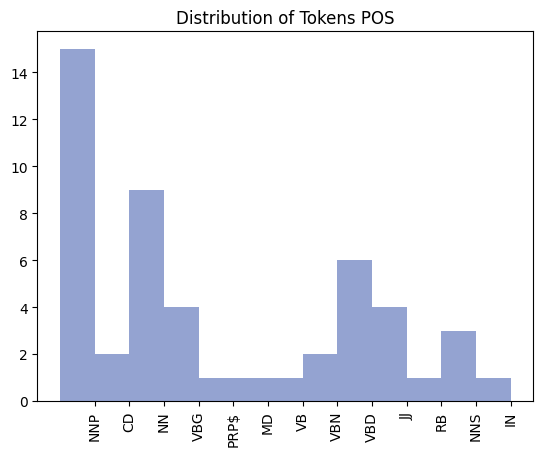

In [39]:
count = count_pos(result)

In [40]:
count

Counter({'NNP': 15,
         'CD': 2,
         'NN': 9,
         'VBG': 4,
         'PRP$': 1,
         'MD': 1,
         'VB': 1,
         'VBN': 2,
         'VBD': 6,
         'JJ': 4,
         'RB': 1,
         'NNS': 3,
         'IN': 1})

In [41]:
%%capture
result = wrap(10, k=5)

loading configuration file /data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000/config.json
Model config MarianConfig {
  "_name_or_path": "/data2/hanyings/opus-mt-en-zh-finetuned-en-to-zh-1109/checkpoint-208000",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      65000
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 65000,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "extra_pos_embeddings": 0,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token

In [42]:
result

[{'translation': {'en': '28-Year-Old Chef Found Dead at San Francisco Mall',
   'zh': '28岁厨师被发现死于旧金山一家商场'},
  'top_tokens': ['Found', 'Chef', 'll']},
 {'translation': {'en': 'A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.',
   'zh': '近日刚搬至旧金山的一位28岁厨师本周被发现死于当地一家商场的楼梯间。'},
  'top_tokens': ['mall', 'was', 'of', 'a', 'had']},
 {'translation': {'en': 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."',
   'zh': '但受害人的哥哥表示想不出有谁会想要加害于他，并称“一切终于好起来了。”'},
  'top_tokens': ['to', 'he', 'for', 's', 'were']},
 {'translation': {'en': "The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.",
   'zh': '旧金山验尸官办公室表示，周三早上于西田购物中心发现的尸体确认为28岁旧金山居民 Frank Galicia。'},
  'top_tokens': ['The', 'the', 'the', 's']},
 {'translation': {'en': 'The S